<a href="https://colab.research.google.com/github/Basel-byte/Speech-Emotion-Recognition/blob/L_trial/Model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from scipy.io import wavfile
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, load_model
from tensorflow.keras import regularizers
from sklearn.metrics import f1_score, confusion_matrix
import os

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dir_path = "/content/drive/MyDrive/Crema"
if not os.path.exists(dir_path):
  !unzip /content/drive/MyDrive/Crema.zip -d /content/drive/MyDrive/Crema

In [5]:
labels = []
audio_waves = []
for file_name in os.listdir(dir_path):
  labels.append(file_name[9:12])
  audio_waves.append(librosa.load(os.path.join(dir_path, file_name)))
print(labels)
lb = LabelBinarizer()
encoded_labels = lb.fit_transform(labels)
print(encoded_labels.shape)
lb.classes_

['NEU', 'HAP', 'FEA', 'HAP', 'HAP', 'DIS', 'NEU', 'DIS', 'NEU', 'SAD', 'HAP', 'HAP', 'DIS', 'ANG', 'HAP', 'FEA', 'SAD', 'ANG', 'SAD', 'ANG', 'FEA', 'ANG', 'SAD', 'SAD', 'NEU', 'FEA', 'HAP', 'DIS', 'DIS', 'FEA', 'HAP', 'ANG', 'DIS', 'SAD', 'HAP', 'NEU', 'HAP', 'DIS', 'DIS', 'DIS', 'ANG', 'HAP', 'NEU', 'SAD', 'DIS', 'ANG', 'ANG', 'DIS', 'ANG', 'HAP', 'FEA', 'ANG', 'HAP', 'NEU', 'FEA', 'NEU', 'HAP', 'DIS', 'HAP', 'HAP', 'NEU', 'HAP', 'NEU', 'DIS', 'NEU', 'HAP', 'NEU', 'ANG', 'DIS', 'SAD', 'SAD', 'SAD', 'NEU', 'ANG', 'NEU', 'SAD', 'DIS', 'ANG', 'ANG', 'FEA', 'FEA', 'FEA', 'SAD', 'DIS', 'SAD', 'DIS', 'SAD', 'FEA', 'FEA', 'FEA', 'FEA', 'NEU', 'FEA', 'FEA', 'DIS', 'FEA', 'ANG', 'ANG', 'HAP', 'SAD', 'HAP', 'NEU', 'SAD', 'NEU', 'HAP', 'HAP', 'ANG', 'ANG', 'SAD', 'HAP', 'HAP', 'NEU', 'FEA', 'ANG', 'DIS', 'ANG', 'SAD', 'FEA', 'ANG', 'ANG', 'DIS', 'SAD', 'HAP', 'HAP', 'SAD', 'ANG', 'HAP', 'ANG', 'DIS', 'DIS', 'DIS', 'HAP', 'DIS', 'NEU', 'DIS', 'NEU', 'HAP', 'DIS', 'HAP', 'FEA', 'NEU', 'NEU', 'HAP'

array(['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'], dtype='<U3')

In [6]:
# def get_spectogram_circular_padded(mel_spec, max_frames):
#   n_frames = mel_spec[1]
#   n_pad_left = (max_frames - n_frames) // 2
#   n_pad_right = max_frames - n_frames - n_pad_left
#   left_pad = mel_spec[:, -n_pad_left:]
#   right_pad = mel_spec[:, :n_pad_right]
#   return np.hstack((left_pad, mel_spec, right_pad))

def get_spectogram_circulary_padded(mel_spec, max_frames):
  n_frames = mel_spec.shape[1]
  if n_frames < max_frames:
    n_pad = max_frames - n_frames
    n = n_pad // n_frames
    mod = n_pad % n_frames
    pad = mel_spec[:, :mod]
    result = np.hstack((mel_spec, pad))
    for i in range(n):
      result = np.hstack((result, mel_spec))
    return result
  else:
    return mel_spec[:, :max_frames]

# get_spectogram_circulary_padded(librosa.feature.melspectrogram(y=audio_waves[20][0]), max_frames)

In [7]:
max_frames = 200
data2 = np.empty((len(labels), 128, max_frames))
for i, audio in enumerate(audio_waves):
  signal, sr = audio
  mel_spec = librosa.feature.melspectrogram(y=signal)
  mel_spec = get_spectogram_circulary_padded(mel_spec, max_frames)
  # delta1 = librosa.feature.delta(mel_spec, delta=1)delta1
  data2[i] = np.array((mel_spec ))

In [8]:
# del delta1
del mel_spec
del audio_waves

In [9]:
np.expand_dims(data2, axis=-1)
train_data2, test_data2, train_labels2, test_labels2 = train_test_split(data2, encoded_labels, test_size=0.3, stratify=encoded_labels, random_state=42)
train_data2, valid_data2, train_labels2, valid_labels2 = train_test_split(train_data2, train_labels2, test_size=0.05, stratify=train_labels2, random_state=42)

In [10]:
del data2

In [11]:
cnn1 =  keras.Sequential([
      keras.layers.Conv2D(50, kernel_size=(3, 3), activation='relu',input_shape=(128,200,1)),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(70, kernel_size=(5, 5), activation='relu'),
      keras.layers.MaxPooling2D(pool_size=(2, 2)),

      keras.layers.Conv2D(90, kernel_size=(7, 7), activation='relu'),
            keras.layers.BatchNormalization(),

      keras.layers.Conv2D(200, kernel_size=(9, 9), activation='sigmoid'),
            keras.layers.BatchNormalization(),

      keras.layers.MaxPooling2D(pool_size=(2, 2)),
      keras.layers.Conv2D(350, kernel_size=(3, 13), activation='sigmoid',kernel_regularizer=regularizers.l2(0.01)),
      keras.layers.Conv2D(500, kernel_size=(3, 3), activation='sigmoid'),
keras.layers.Dropout(0.2),

      keras.layers.Flatten(),
      keras.layers.Dense(300, activation='relu', kernel_regularizer=regularizers.l1(0.01)),

      keras.layers.Dense(120, activation='relu', kernel_regularizer=regularizers.l1(0.01)),
      keras.layers.Dense(84, activation='relu'),
      keras.layers.Dense(6, activation='softmax')
])
# # Compile the model
cnn1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 198, 50)      500       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 99, 50)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 63, 99, 50)       200       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 95, 70)        87570     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 47, 70)       0         
 2D)                                                             
                                                        

In [15]:
tests = []
# Train the model
cnn1 = load_model('/content/drive/MyDrive/models/models2.h5')
# history = cnn1.fit(train_data2, train_labels2, epochs=450, batch_size=64, validation_data=(valid_data2, valid_labels2))
cnn1.summary()
# Print the training accuracy for each epoch
# for epoch, acc in enumerate(history.history['accuracy']):
#     print("Epoch {}: training accuracy = {}".format(epoch, acc))
test_loss, test_acc = cnn1.evaluate(test_data2, test_labels2)
tests.append(test_acc)
print('Test accuracy:', test_acc)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 126, 198, 15)      150       
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 63, 99, 15)       0         
 g2D)                                                            
                                                                 
 conv2d_56 (Conv2D)          (None, 59, 95, 30)        11280     
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 29, 47, 30)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 23, 41, 50)        73550     
                                                                 
 conv2d_58 (Conv2D)          (None, 15, 33, 300)     

In [ ]:
cnn1.save('models4.h5')

In [ ]:
del cnn1

In [ ]:


model = keras.Sequential()
model.add(keras.layers.Conv2D(8, (13, 13), input_shape=(128,200,1)))
model.add(keras.layers.BatchNormalization(axis=-1))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Activation('relu'))
# model.add(keras.layers.Conv2D(8, (13, 13), kernel_regularizer=regularizers.l1(0.01)))
# model.add(keras.layers.BatchNormalization(axis=-1))
# model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 1)))
model.add(keras.layers.Conv2D(8, (3, 3), kernel_regularizer=regularizers.l1(0.01)))
model.add(keras.layers.BatchNormalization(axis=-1))
model.add(keras.layers.Activation('relu'))
# model.add(keras.layers.Conv2D(8, (1, 1), kernel_regularizer=regularizers.l1(0.01)))
# model.add(keras.layers.BatchNormalization(axis=-1))
# model.add(keras.layers.Dropout(0.2))

# model.add(keras.layers.Activation('relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 1)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(6, activation = 'softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 116, 188, 8)       1360      
                                                                 
 batch_normalization_25 (Bat  (None, 116, 188, 8)      32        
 chNormalization)                                                
                                                                 
 dropout_10 (Dropout)        (None, 116, 188, 8)       0         
                                                                 
 activation_27 (Activation)  (None, 116, 188, 8)       0         
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 58, 188, 8)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 56, 186, 8)       

In [ ]:

history = model.fit(train_data2, train_labels2, epochs=30, batch_size=32, validation_data=(valid_data2, valid_labels2))

# Print the training accuracy for each epoch
for epoch, acc in enumerate(history.history['accuracy']):
    print("Epoch {}: training accuracy = {}".format(epoch, acc))
test_loss, test_acc = model.evaluate(test_data2, test_labels2)
print('Test accuracy:', test_acc)

Epoch 1/30
155/155 [==============================] - 5s 23ms/step - loss: 2.3004 - accuracy: 0.2641 - val_loss: 2.1764 - val_accuracy: 0.2835
Epoch 2/30
155/155 [==============================] - 3s 21ms/step - loss: 2.1070 - accuracy: 0.2971 - val_loss: 2.0944 - val_accuracy: 0.2567
Epoch 3/30
155/155 [==============================] - 3s 22ms/step - loss: 1.9619 - accuracy: 0.3215 - val_loss: 2.0164 - val_accuracy: 0.2644
Epoch 4/30
155/155 [==============================] - 3s 21ms/step - loss: 1.8195 - accuracy: 0.3745 - val_loss: 2.0389 - val_accuracy: 0.2222
Epoch 5/30
155/155 [==============================] - 3s 21ms/step - loss: 1.6716 - accuracy: 0.4177 - val_loss: 1.8564 - val_accuracy: 0.3487
Epoch 6/30
155/155 [==============================] - 3s 21ms/step - loss: 1.5711 - accuracy: 0.4479 - val_loss: 2.1780 - val_accuracy: 0.1648
Epoch 7/30
155/155 [==============================] - 3s 22ms/step - loss: 1.4798 - accuracy: 0.4808 - val_loss: 2.2128 - val_accuracy: 0.1686

KeyboardInterrupt: ignored

In [16]:


def plot(confusion_matrix, class_labels):
  fig, ax = plt.subplots()
  im = ax.imshow(cm)
  # Add the colorbar
  cbar = ax.figure.colorbar(im, ax=ax)

  # Set the tick labels and axis labels
  ax.set_xticks(np.arange(len(class_labels)))
  ax.set_yticks(np.arange(len(class_labels)))
  ax.set_xticklabels(class_labels)
  ax.set_yticklabels(class_labels)

  # Rotate the tick labels and set their alignment
  plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
          rotation_mode="anchor")

  # Loop over data dimensions and create text annotations
  for i in range(len(class_labels)):
      for j in range(len(class_labels)):
          text = ax.text(j, i, confusion_matrix[i, j],
                        ha="center", va="center", color="w")

  # Set the plot title
  ax.set_title("Confusion Matrix")

  # Show the plot
  plt.show()
     


70/70 [==============================] - 1s 9ms/step
F measure:
0.4636976706080342

CofusioN Matrix:


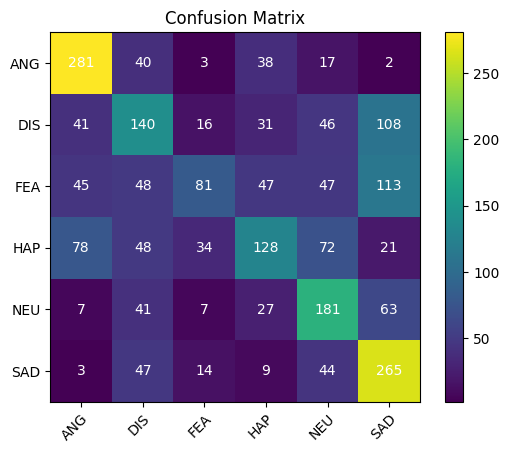


Most Confusing Classes:
class: FEA and class: SAD with 113
class: DIS and class: SAD with 108
class: HAP and class: ANG with 78
class: HAP and class: NEU with 72
class: NEU and class: SAD with 63


In [21]:
# Compute predictions on the test set
loaded_model = load_model('/content/drive/MyDrive/models/models2.h5')
y_pred = loaded_model.predict(test_data2)
y_pred_decrypted = np.argmax(y_pred, axis=1)
test_labels_decrypted = np.argmax(test_labels2, axis=1)
labels_decrypted = lb.classes_

f1 = f1_score(test_labels_decrypted, y_pred_decrypted, average='weighted')
print("F measure:\n============")
print(f1)
print()

print("CofusioN Matrix:\n=================")
N = 5
cm = confusion_matrix(test_labels_decrypted, y_pred_decrypted)
plot(cm, labels_decrypted)
print("\nMost Confusing Classes:\n===============")
cm = np.array(cm)
np.fill_diagonal(cm, 0)
cm_f = cm.flatten()
cm_f = np.flip(cm_f.argsort()[-N:])
for n in cm_f:
  print(f'class: {labels_decrypted[int(n / cm.shape[0])]} and class: {labels_decrypted[n % cm.shape[0]]} with {cm[int(n / cm.shape[0]), n % cm.shape[0]]}')